# Intro

This script compiles the individual tidy_data.csv files in `/app/data/tidy_data_files` into a master csv.
It also generates some summary plots:

* Timeseries plots of individual experiments.
* A series of box plots to represent the variance of the expression at a certain timepoint to be decided.

It then saves a new tidy master csv: containing all of the timepoints for all experiments: `master_tidy_dataset.csv`

## Import some stuff

In [1]:
#import macroparameters

import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import plotly.express as px

    
import os, sys, shutil


def print_all_df(df):
    # Permanently changes the pandas settings
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    
    # All dataframes hereafter reflect these changes.
    display(df)
    
    print('**RESET_OPTIONS**')
    
    # Resets the options
    pd.reset_option('all')
    

# List all the tidy data .csvs in the directory

In [2]:
# navigate into tidy_data_files and make a list of all files

os.chdir('/app/data/tidy_data_files')
os.getcwd()

items = os.listdir(".")

# lists all .csv
csv_list = []
for names in items:
    if names.endswith(".csv"):
        csv_list.append(names)
print(csv_list)



['ALTE006_tidy_data.csv']


First we need to store the max time for each experiment in a list. The experiments vary so this needs to be done dynamically.

# Preliminary time course plotting

First concatentate all dfs and save as `master_tidy_dataset.csv`

In [3]:
all_times = pd.DataFrame()
os.chdir('/app/data/tidy_data_files')

# First combine all dfs
for csv in csv_list:
    
    #import into df
    experiment_tidy_data = pd.read_csv(csv, header=0)
    
    # add the series to the stats df as a row
    all_times = all_times.append(experiment_tidy_data)


    ### save
path = "/app/data/"

# make directory for sticking the output in
if os.path.isdir(path) == False:
    os.mkdir(path, mode=0o777)
    
    
#navigate to tidy_data_files
os.chdir(path)

all_times.to_csv("master_tidy_dataset.csv", index=False)


#navigate home for neatness
os.chdir('/app')


/tmp/ipykernel_632/2173851510.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_times = all_times.append(experiment_tidy_data)


# Now trim the df a bit to only get the same chromatic

In [4]:
all_times = all_times[all_times['Expression Product']=="GFP"]
all_times = all_times[all_times['Gain Setting']==800]
all_times = all_times.reset_index(drop=True)

# Plot individual replicates for each experiments

7
8


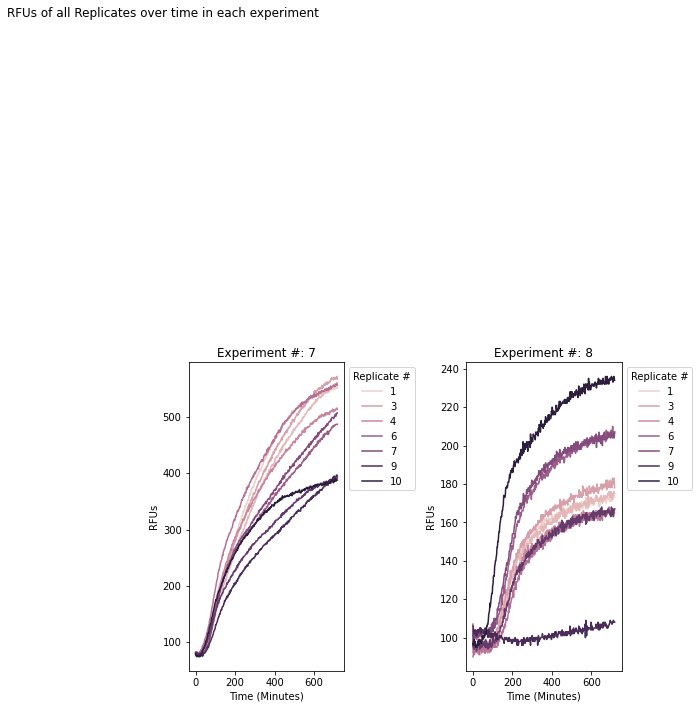

In [5]:
fig = plt.figure(figsize=(15,10))

# Calculate the appropriate amount of subplots and their layout

# Get the total number of experiments
total_experiments = all_times['Experiment #'].unique().max()

if total_experiments%2 == 0:
    subplot_rows = 2
    subplot_cols = int(total_experiments/2)



for exp in all_times['Experiment #'].unique():
    print(exp)
    
    exp_df = all_times[all_times['Experiment #'] == exp]
    
    ax = plt.subplot(subplot_rows, subplot_cols, exp)
    
    sns.lineplot(data = exp_df,
                 x = "Time (Minutes)",
                 y = "RFUs",
                 hue = "Replicate",
                 ax= ax,
                ci=None)
    
    ax.set_title("Experiment #: "+str(exp))
    ax.legend(title="Replicate #", loc = 2, bbox_to_anchor = (1,1))



fig.suptitle("RFUs of all Replicates over time in each experiment")
fig.tight_layout()


##### Save fig


path = "/app/data/plots/"

# make directory for sticking the output in
if os.path.isdir(path) == False:
    os.mkdir(path, mode=0o777)
    
    
#navigate to tidy_data_files
os.chdir(path)

plt.savefig("all_timeseries_rfus.png")


#navigate home for neatness
os.chdir('/app')

plt.show()

# Define the time point to use as an endpoint

Now we have all off the max times, we'll simply set the smallest as the timepoint that we'll use as the endpoint reading this may change.

In [6]:
### initalise df using the columns
os.chdir('/app/data/tidy_data_files')

# iterate over the datasets and store the max time in a list
max_times = []
for csv in csv_list:
    
    #import into df
    experiment_tidy_data = pd.read_csv(csv, header=0)
    max_times.append(experiment_tidy_data['Time (Minutes)'].max())
    
timepoint = min(max_times)
print(timepoint)

#os.chdir('/app')

718


Now we'll slice the individual dataframes to keep only the gain setting we want and the readings at the timepoint identified above. We'll produce a df called stats

In [7]:
### initalise df using the columns
os.chdir('/app/data/tidy_data_files')


# id columns
cols = pd.read_csv(csv_list[0], header=0)
cols = cols.drop(["Sample ID", "Well", "Chromatic Settings"], axis='columns')
cols = cols.columns


stats = pd.DataFrame(columns=cols)

# iterate over the datasets
for csv in csv_list:
    
    #import into df
    experiment_tidy_data = pd.read_csv(csv, header=0)
    
    # get all exp numbs
    for exp_num in experiment_tidy_data['Experiment #'].unique():
        
        # get only individual experiments
        experiment_number_subsection = experiment_tidy_data[experiment_tidy_data['Experiment #'] == exp_num]
    
        # use the time point to slice the dataframe
        timepoint_slice = experiment_number_subsection[experiment_number_subsection['Time (Minutes)'] == timepoint].copy()

        # now just save the right gainsetting
        gain_setting_slice = timepoint_slice[timepoint_slice['Gain Setting'] == 800].copy()
        # now just save the right gainsetting
        gain_setting_slice = gain_setting_slice[gain_setting_slice['Expression Product'] == "GFP"].copy()

        # generate stats
        gain_setting_slice['Mean'] = gain_setting_slice['RFUs'].mean()

        # standard deviation
        gain_setting_slice['STD'] = gain_setting_slice['RFUs'].std()

        # Coeffiecent of variance
        gain_setting_slice['CV'] = gain_setting_slice['STD'] / gain_setting_slice['Mean']


        # Drop the stuff we don't need.
        gain_setting_slice = gain_setting_slice.reset_index(drop=True)
        gain_setting_slice = gain_setting_slice.drop([ "Sample ID", "Well", "Chromatic Settings"], axis='columns')

        # add the series to the stats df as a row
        stats = stats.append(gain_setting_slice)



stats = stats.reset_index(drop=True)
print_all_df(stats)


/tmp/ipykernel_632/2808224412.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats = stats.append(gain_setting_slice)
/tmp/ipykernel_632/2808224412.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats = stats.append(gain_setting_slice)
/tmp/ipykernel_632/4012125076.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Time (Minutes),RFUs,Gain Setting,Expression Product,Amplicon DNA Template,Energy Solution,Experiment #,Reaction Type,Replicate,System,lysate_aspirate_height_inc,lysate_aspirate_height_init,substrates_aspirate_height_inc,substrates_aspirate_height_init,wax_air_gap,wax_dispense_height,wax_dispense_volume,wax_disposal_volume,wax_new_tip,wax_touch_tip,Reaction Temperature (°C),Performed by,Instrument,Plate Reader Run #,Assay Date,Mean,STD,CV
0,718,552,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,1,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
1,718,561,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,2,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
2,718,567,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,3,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
3,718,513,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,4,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
4,718,557,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,5,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
5,718,487,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,6,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
6,718,507,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,7,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
7,718,392,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,8,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
8,718,395,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,9,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197
9,718,388,800,GFP,s70_deGFP_MGA,AP_ES_004,7,TXTL,10,AP_Lysate_004,0.4,4.5,0.6,8.6,20,-3,35,30,never,False,37,AP & MJS,BMG POLARstar Omega,6,2022-06-21,491.9,73.881963,0.150197


**RESET_OPTIONS**


/usr/local/lib/python3.10/dist-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


# Box plot of each experiment

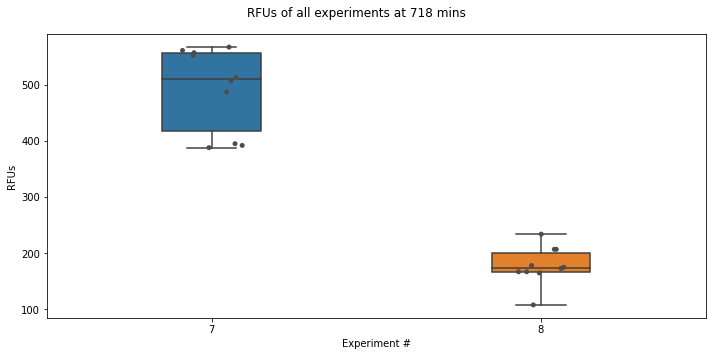

In [9]:
fig = plt.figure(figsize=(10,5))

ax = sns.boxplot(x="Experiment #", y="RFUs", data=stats, whis=np.inf, width=0.3)
ax = sns.stripplot(x="Experiment #", y="RFUs", data=stats, color=".3")

#ax.set_ylim(0,300)

fig.suptitle("RFUs of all experiments at "+ str(timepoint) + " mins")
fig.tight_layout()


##### Save fig


path = "/app/data/plots/"

# make directory for sticking the output in
if os.path.isdir(path) == False:
    os.mkdir(path, mode=0o777)
    
    
#navigate to tidy_data_files
os.chdir(path)

plt.savefig("experiment_rounds_box_plots.png")


#navigate home for neatness
os.chdir('/app')

plt.show()

In [10]:
test = stats[["Experiment #", "CV"]].drop_duplicates()
test

,Experiment #,CV
0,7,0.150197
10,8,0.188679


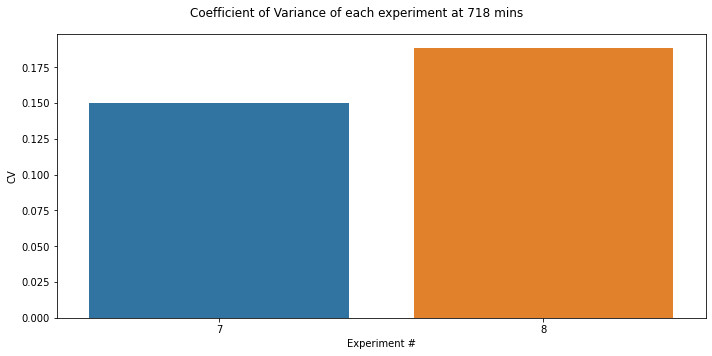

In [12]:
fig = plt.figure(figsize=(10,5))

ax = sns.barplot(x="Experiment #", y="CV", data=test)

#ax.set_ylim(0,300)

fig.suptitle("Coefficient of Variance of each experiment at "+ str(timepoint) + " mins")
fig.tight_layout()

